In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

# Set path to find modelling tools for later use
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))


from haberrspd.preprocess import create_long_form_English_MJFF_dataset

import pandas as pd
import numpy as np
print(np.__version__)
from collections import Counter, defaultdict
import itertools
from operator import itemgetter
from scipy.stats import (gamma, lognorm, gengamma)

from pathlib import Path
from IPython.display import display

# Plot stuff
import seaborn as sns
from scipy.constants import golden
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Depending on where I am, set the path
import socket
if socket.gethostname() == 'pax':
    # Monster machine
    data_root = '../data/MJFF/' # My local path
    data_root = Path(data_root)
else:
    # Laptop
    data_root = '/home/nd/data/liverpool/MJFF' # My local path
    data_root = Path(data_root)

1.16.4


----

In [3]:
# Meta
df_meta = pd.read_csv(data_root / "EnglishParticipantKey.csv",  
                      header=0, 
                      names=['participant_id', 'ID', 'attempt', 'diagnosis'], 
                      usecols=['participant_id', 'diagnosis'])
# Actual
df = pd.read_csv(data_root / "EnglishData.csv")

In [2]:
out, reference = create_long_form_English_MJFF_dataset()

/home/neil/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2731: RuntimeWarning: divide by zero encountered in power
  return np.where(c > 0, val1, val2)**(1.0/c)


AssertionError: INFO:
	 value: -28568.00060604794 
	 sentence ID: 57

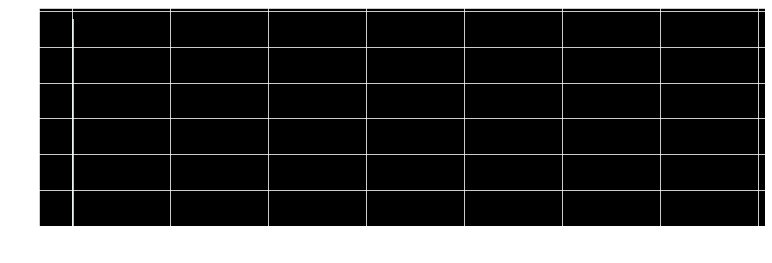

In [18]:
df.loc[df.sentence_id == 57].timestamp.diff().hist(figsize=(13,4),bins=500)

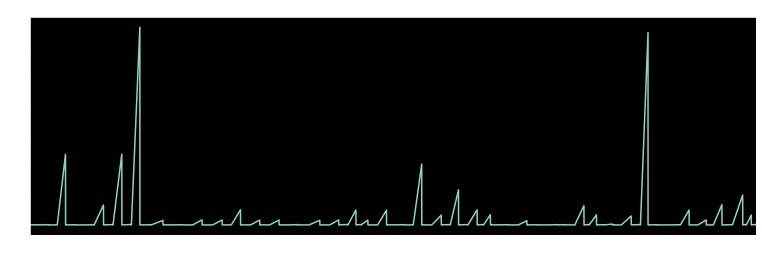

In [20]:
df.loc[df.sentence_id == 57].timestamp.diff().plot(figsize=(13,4))

In [28]:
for i in set(df.participant_id):
    if df.loc[(df.sentence_id == 57) & (df.participant_id == i)].timestamp.diff().min() < 0:
        print(i)

39b


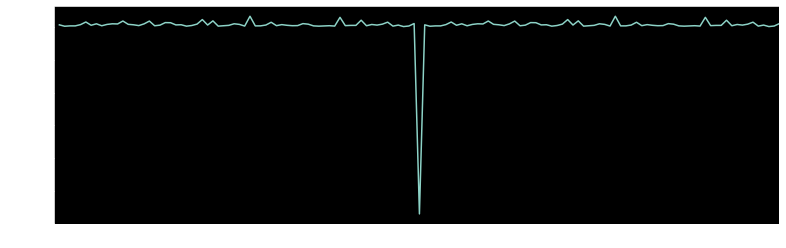

In [32]:
df.loc[(df.sentence_id == 57) & (df.participant_id == '39b')].timestamp.diff().plot(figsize=(13,4))

In [56]:
x = np.array([1,2,34,5,5,-1,5])

In [52]:
np.where((x > 15) or (x < 0), 99999, x)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [57]:
np.where(np.logical_or(x > 15, x < 0), 9999, x).astype(int)

array([   1,    2, 9999,    5,    5, 9999,    5])

In [ ]:
np.logical_or

## PLOT

In [15]:
controls = set(df_meta.loc[df_meta.diagnosis == 0].participant_id)
pd_subjects = set(df_meta.loc[df_meta.diagnosis == 1].participant_id)

In [16]:
pd_timestamp_diffs = []
# Loop over all subjects
for sub in pd_subjects:
    # Get all delta timestamps for this sentence, across all subjects
    pd_timestamp_diffs.extend(df.loc[(df.sentence_id == 57) & (df.participant_id == sub)].timestamp.diff().values)
    
control_timestamp_diffs = []
# Loop over all subjects
for sub in controls:
    # Get all delta timestamps for this sentence, across all subjects
    control_timestamp_diffs.extend(df.loc[(df.sentence_id == 57) & (df.participant_id == sub)].timestamp.diff().values)

In [17]:
# remove NaNs
pd_cleaned_list = [x for x in pd_timestamp_diffs if str(x) != 'nan']
control_cleaned_list = [x for x in control_timestamp_diffs if str(x) != 'nan']

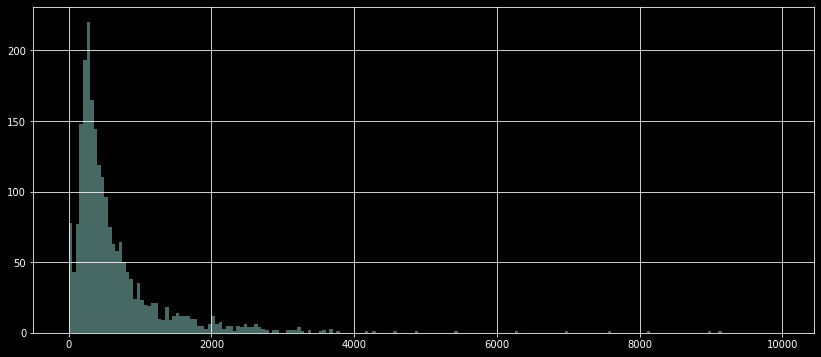

In [19]:
# PD

# fixed bin size
bins = np.arange(0, 10000, 50) # fixed bin size
# plt.xlim([min(data)-5, max(data)+5])
fig = plt.figure(figsize=(14,6))
plt.hist(pd_cleaned_list, bins=bins, alpha=0.5)
# plt.vlines(np.quantile(cleaned_list,0.95),0,900,'r')
# plt.vlines(np.mean(cleaned_list),0,900,'b')
plt.grid(True)
plt.show()

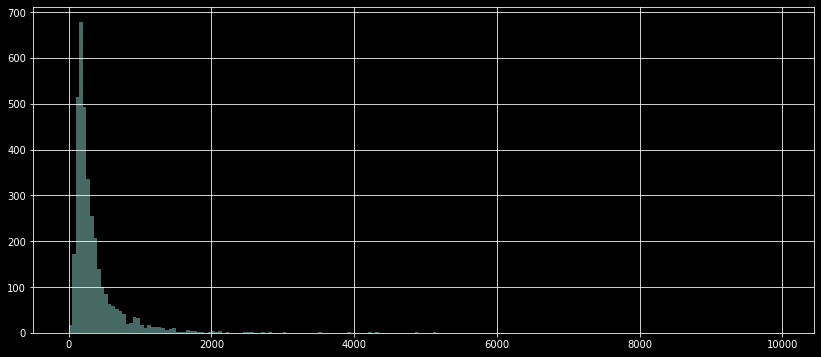

In [20]:
# control

# fixed bin size
bins = np.arange(0, 10000, 50) # fixed bin size
# plt.xlim([min(data)-5, max(data)+5])
fig = plt.figure(figsize=(14,6))
plt.hist(control_cleaned_list, bins=bins, alpha=0.5)
# plt.vlines(np.quantile(cleaned_list,0.95),0,900,'r')
# plt.vlines(np.mean(cleaned_list),0,900,'b')
plt.grid(True)
plt.show()

### Save the English data to use in downstream tasks

In [7]:
out.to_csv(data_root /'preprocessed_EnglishData.csv',index=False)
reference.to_csv(data_root /'EnglishData_target_sentences.csv',index=False)

### Mechanical turk data

In [15]:
out.to_csv(data_root /'preprocessed_MechanicalTurkCombinedEnglishData.csv',index=False)

In [14]:
ls ../data/MJFF/

EnglishData.csv
EnglishParticipantKey.csv
fasttext/
MechanicalTurkCombinedEnglishData.csv
MechanicalTurkEnglishParticipantKey.csv
MTurk1.csv
MTurk2.csv
preprocessed_EnglishData.csv
preprocessed_MechanicalTurkCombinedEnglishData.csv
README
SpanishData.csv
SpanishParticipantKey.csv
test_MJFF_English.csv
train_MJFF_English.csv
validate_MJFF_English.csv


### IKI extraction

In [4]:
out = create_mjff_iki_training_data(df)

In [6]:
out['10a'][0]

array([    0,   141,   235,   323,   414,   525,   723,   940,  1081,
        1161,  1215,  1290,  1573,  1687,  1778,  1885,  2000,  2465,
        2689,  2769,  2926,  3044,  3122,  3189,  3508,  3703,  3796,
        3942,  4053,  4196,  4464,  4663,  4777,  4875,  4973,  5081,
        5230,  5341,  5453,  5480,  5597,  5758,  6091,  6332,  6342,
        6813,  6934,  7104,  7242,  7381,  7471,  7518,  7690,  7774,
        7914,  8089,  8250,  8377,  8531,  9315,  9357,  9879,  9965,
       10131, 10258, 10366, 10445, 10589, 10680, 10754, 10826, 10952,
       11016, 11124, 11204, 11385, 11545, 11753, 11891, 12135, 12496,
       12839, 13018, 13115, 13184, 13351, 13719, 13935, 14118, 14641,
       14724, 15892, 16062, 16332, 16462, 16584, 16906, 16981, 17413,
       17541, 17696, 17758, 17834, 17986, 18108, 18122, 18193, 18348,
       18529, 18923, 19083, 19224, 19555, 19749, 20011, 20052, 20179,
       20259, 20714, 20847, 21805, 21920, 22047, 22534, 22981, 23118,
       24108, 24205,

## Add Spanish data

In [2]:
test = create_NLP_datasets_from_MJFF_Spanish_data()

/home/neil/cloud/haberrspd/notebooks/../haberrspd/preprocess.py:263: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  invoked_sentence = np.delete(sentence, remove_cords).tolist()


In [5]:
test.to_csv(data_root /'preprocessed_SpanishData.csv',index=False)

## Long format data

In [3]:
from haberrspd.preprocess import create_char_compression_time_mjff_data, create_long_form_NLP_datasets_from_MJFF_English_data

In [97]:
df.loc[df.participant_id.isin(['10a','1a'])].shape

(3912, 9)